<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap20/20_2_Full_Batch_Gradient_Descent_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 20.2: Full Batch Gradient Descent**

This notebook investigates training a network with full batch gradient descent as in figure 20.2.  This is the GPU version (notebook takes a long time to run).  If you are using Colab then you need to go change the runtime type to GPU on the Runtime menu.  Even then, you may run out of time.  If that's the case, you'll need to download the Python file and run locally.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.



In [ ]:
# Run this if you're in a Colab to install MNIST 1D repository
!pip install git+https://github.com/greydanus/mnist1d

In [1]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random
from IPython.display import display, clear_output


# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cuda


In [2]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y']
print("Examples in training set: {}".format(len(data['y'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Length of each example: 40


Define the network

In [8]:
# Data is length forty, and there are 10 classes
D_i = 40
D_o = 10

# create model with one hidden layer and 298 hidden units
model_1_layer = nn.Sequential(
nn.Linear(D_i, 298),
nn.ReLU(),
nn.Linear(298, D_o))


# TODO -- create model with three hidden layers and 100 hidden units per layer
# Replace this line
model_2_layer = nn.Sequential(
    nn.Linear(D_i, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),    
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, D_o),
)

# TODO -- Create model with three hidden layers and 75 hidden units per layer
# Replace this line
model_3_layer = nn.Sequential(
    nn.Linear(D_i, 75),
    nn.ReLU(),
    nn.Linear(75, 75),
    nn.ReLU(),    
    nn.Linear(75, 75),
    nn.ReLU(),
    nn.Linear(75, D_o),
)

# TODO create model with four hidden layers and 63 hidden units per layer
# Replace this line
model_4_layer = nn.Sequential(
    nn.Linear(D_i, 63),
    nn.ReLU(),
    nn.Linear(63, 63),
    nn.ReLU(),    
    nn.Linear(63, 63),
    nn.ReLU(),
    nn.Linear(63, D_o),
)

In [9]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [10]:
def train_model(model, train_data_x, train_data_y, n_epoch, DEVICE):
  print("This is going to take a long time!")
  # choose cross entropy loss function (equation 5.24 in the loss notes)
  loss_function = nn.CrossEntropyLoss()
  # construct SGD optimizer and initialize learning rate to small value and momentum to 0
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.0025, momentum=0.0)
  # create 100 dummy data points and store in data loader class
  x_train = torch.tensor(train_data_x.transpose(), dtype=torch.float32, device=DEVICE)
  y_train = torch.tensor(train_data_y, dtype=torch.long, device=DEVICE)

  # load the data into a class that creates the batches -- full batch as there are 4000 examples
  data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=4000, shuffle=False, worker_init_fn=np.random.seed(1))

  # Initialize model weights
  model.apply(weights_init)

  # store the errors percentage at each point
  errors_train = np.zeros((n_epoch))

  for epoch in range(n_epoch):
    # loop over batches
    for i, data in enumerate(data_loader):
      # retrieve inputs and labels for this batch
      x_batch, y_batch = data
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward pass -- calculate model output
      pred = model(x_batch)
      # compute the loss
      loss = loss_function(pred, y_batch)
      # Store the errors
      _, predicted_train_class = torch.max(pred.data, 1)
      errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
      # backward pass
      loss.backward()
      # SGD update
      optimizer.step()

      if epoch % 10 == 0:
        clear_output(wait=True)
        display("Epoch %d, errors_train %3.3f"%(epoch, errors_train[epoch]))

  return errors_train

In [11]:
# Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)


In [13]:
# Train the four models
model_4_layer = model_4_layer.to(DEVICE)
errors_four_layers = train_model(model_4_layer, train_data_x, train_data_y, n_epoch=2000, DEVICE=DEVICE)


'Epoch 1990, errors_train 65.875'

In [14]:
model_3_layer = model_3_layer.to(DEVICE)
errors_three_layers = train_model(model_3_layer, train_data_x, train_data_y, n_epoch=2000, DEVICE=DEVICE)


'Epoch 1990, errors_train 65.975'

In [15]:
model_2_layer = model_2_layer.to(DEVICE)
errors_two_layers = train_model(model_2_layer, train_data_x, train_data_y, n_epoch=2000, DEVICE=DEVICE)


'Epoch 1990, errors_train 63.225'

In [16]:
model_1_layer = model_1_layer.to(DEVICE)
errors_one_layer = train_model(model_1_layer, train_data_x, train_data_y, n_epoch=5000, DEVICE=DEVICE)

'Epoch 4990, errors_train 54.625'

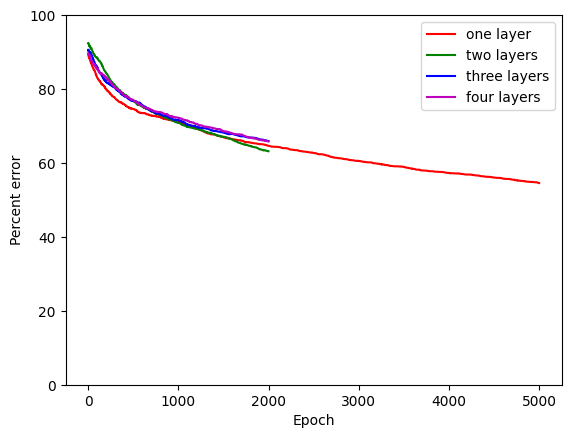

In [17]:
# Plot the results
# Indeed, would take a long time. I won't be able to do the full experiment with 200000 and 500000 epochs.
fig, ax = plt.subplots()
ax.plot(errors_one_layer,'r-',label='one layer')
ax.plot(errors_two_layers,'g-',label='two layers')
ax.plot(errors_three_layers,'b-',label='three layers')
ax.plot(errors_four_layers,'m-',label='four layers')
ax.set_ylim(0,100)
ax.set_xlabel('Epoch'); ax.set_ylabel('Percent error')
ax.legend()
plt.show()